In [1]:
import time
start_time = time.time()

In [2]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from MultiTimeframeCandleManager import MultiTimeframeCandleManager
from datetime import datetime, timedelta
import time
from collections import deque
import numpy as np
import copy
import tensorflow as tf
from tqdm import tqdm
import random
from save_and_load import *
from Candle import Candle
import matplotlib.pyplot as plt

candles = obj_load("NQ_1")[600000:]
len(candles)

loading NQ_1


250000

In [3]:
num_actions = 3

In [4]:

lrelu = tf.keras.layers.LeakyReLU(0.05)


chart_m15 = tf.keras.layers.Input(shape = (60,4))
chart_m5 = tf.keras.layers.Input(shape = (60,4))
chart_m1 = tf.keras.layers.Input(shape = (60,4))

pdas = tf.keras.layers.Input(shape = (3*3+3*3+1+12*5+5*3,))

current_position = tf.keras.layers.Input(shape = (3,))

minutes = tf.keras.layers.Input(shape = (1,))
minutes_embed = tf.keras.layers.Embedding(input_dim=60*24, output_dim=8)(minutes)
minutes_embed_flat = tf.keras.layers.Flatten()(minutes_embed)

f15 = tf.keras.layers.Flatten()(chart_m15)
f5 = tf.keras.layers.Flatten()(chart_m5)
f1 = tf.keras.layers.Flatten()(chart_m1)

pdas_repeated = tf.keras.layers.Lambda(
lambda inputs: tf.repeat(tf.expand_dims(inputs, axis = 1), repeats=60, axis=1)
)(pdas)

concatenated_m5_at = tf.keras.layers.Concatenate(axis=-1)([chart_m5, pdas_repeated])
m5_at = tf.keras.layers.Dense(512)(concatenated_m5_at)
m5_at = lrelu(m5_at)
m5_at = tf.keras.layers.Dense(256)(m5_at)
m5_at = lrelu(m5_at)
m5_at = tf.keras.layers.Dense(128)(m5_at)
m5_at = lrelu(m5_at)
m5_at = tf.keras.layers.LSTM(512)(m5_at)

concatenated_m1_at = tf.keras.layers.Concatenate(axis=-1)([chart_m1, pdas_repeated])
m1_at = tf.keras.layers.Dense(512)(concatenated_m1_at)
m1_at = lrelu(m1_at)
m1_at = tf.keras.layers.Dense(256)(m1_at)
m1_at = lrelu(m1_at)
m1_at = tf.keras.layers.Dense(128)(m1_at)
m1_at = lrelu(m1_at)
m1_at = tf.keras.layers.LSTM(512)(m1_at)


#c = tf.keras.layers.Concatenate()([f15, f5, f1, pdas, minutes_embed_flat, current_position, scaled_open_profit])
c = tf.keras.layers.Concatenate()([f15, f5, f1, pdas, minutes_embed_flat, current_position, m1_at, m5_at])

d = tf.keras.layers.Dense(4096*4)(c)
d = lrelu(d)
d = tf.keras.layers.Dense(4096*4)(d)
d = lrelu(d)
d = tf.keras.layers.Dense(4096*2)(d)
d = lrelu(d)
d = tf.keras.layers.Dense(4096*1)(d)
d = lrelu(d)


value = tf.keras.layers.Dense(1, activation="linear")(d)
advantage = tf.keras.layers.Dense(num_actions, activation="linear")(d)

q_values = tf.keras.layers.Lambda(
lambda inputs: inputs[0] + (inputs[1] - tf.reduce_mean(inputs[1], axis=1, keepdims=True))
)([value, advantage])

outputs = tf.keras.layers.Activation('linear', dtype='float32')(q_values)

model = tf.keras.Model(inputs = [chart_m15, chart_m5, chart_m1, pdas, minutes, current_position], outputs = outputs)


model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 94)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 60, 4)]      0           []                               
                                                                                                  
 lambda (Lambda)                (None, 60, 94)       0           ['input_4[0][0]']                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 60, 98)       0           ['input_3[0][0]',                
                                                                  'lambda[0][0]']             

In [5]:
model.load_weights("model.weights.h5")

In [6]:

def relative (value, center, r):
        return (value - center) / r

def ret_to_scaled_inputs(ret):

    midnight_open, midnight_opening_range_high,midnight_opening_range_low, pdas, current_close, current_time, charts = ret


    center = (midnight_opening_range_high + midnight_opening_range_low) / 2
    r = max(0.0001,(midnight_opening_range_high - midnight_opening_range_low) / 2)

    pda_rel = []
    pda_rel.append(relative(midnight_open, center, r))
    for pda in pdas[0:9+9+15]:
        pda_rel.append(relative(pda, center, r))
    for index in range(9+9+15,9+9+15+5*12):
        ## highs lows are like this [h, h_taken, l, l_taken]
        ## the bools should not be scaled
        if (index - 9+9+15) % 2 == 0:
            pda_rel.append(relative(pdas[index], center, r))
        else:
            pda_rel.append(pdas[index])

    pda_np = np.array(pda_rel)

    current_minutes = current_time.hour * 60 + current_time.minute

    charts_array = []
    for candlesticks in charts:
        charts_array.append([])
        for candle in candlesticks:
            o = relative(candle.o, center, r)
            h = relative(candle.h, center, r)
            l = relative(candle.l, center, r)
            c = relative(candle.c, center, r)
            charts_array[-1].append([o,h,l,c])

    m15_np = np.array(charts_array[0])
    m5_np = np.array(charts_array[1])
    m1_np = np.array(charts_array[2])

    return [m15_np, m5_np, m1_np, pda_np, current_minutes]


# In[11]:


class Order:
    def __init__(self, limit, stop, tp, direction):
        self.entry = limit
        self.tp = tp
        self.sl = stop
        self.direction = direction

class Position:
    def __init__(self, entry, stop, tp, direction):
        self.entry = entry
        self.tp = tp
        self.sl = stop
        self.direction = direction


In [7]:
def step(index):

        global current_position, current_order, slm, m, outputs, all_candles, cmm, equity, equity_L
    
        ret = m.push_m1_candle(candles[index])
        midnight_open, midnight_opening_range_high,midnight_opening_range_low, pdas, current_close, current_time, charts = ret
        center = (midnight_opening_range_high + midnight_opening_range_low) / 2
        r = max(0.0001, (midnight_opening_range_high - midnight_opening_range_low) / 2)



        current_candle_m1 = charts[2][-1]
        #### check tp before filling order so that the same m1 candle will not trigger tp - it is not sure if the candle hit first limit and later tp or reve3rse
        if current_position.direction == 1:
            if current_candle_m1.h >= current_position.tp:
                pnl = (current_position.tp - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)
        if current_position.direction == -1:
            if current_candle_m1.l <= current_position.tp:
                pnl = (current_position.tp - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)

        #### check order
        if current_order != None:
            if  current_order.direction == 1:
                if current_candle_m1.l < current_order.entry:
                    current_position = Position(current_order.entry, current_order.sl, current_order.tp, current_order.direction)
                    #print("fill long order:",current_order.entry, current_order.sl, current_order.tp)
                    equity -= cmm
                    current_order = None
        if current_order != None:
            if  current_order.direction == -1:
                if current_candle_m1.h > current_order.entry:
                    current_position = Position(current_order.entry, current_order.sl, current_order.tp, current_order.direction)
                    #print("fill short order:",current_order.entry, current_order.sl, current_order.tp)
                    equity -= cmm
                    current_order = None

        #### check sl
        if current_position.direction == 1:
            if current_candle_m1.l <= current_position.sl:
                pnl = (current_position.sl - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)
        if current_position.direction == -1:
            if current_candle_m1.h >= current_position.sl:
                pnl = (current_position.sl - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)




        if(len(m.ndogs) == 5 and len(m.fps) == 3 and len(m.opening_range_gaps) == 3 and len(m.asia_highs_lows) == 3 and len(m.london_highs_lows) == 3 and len(m.ny_am_highs_lows) == 3 and len(m.ny_lunch_highs_lows) == 3 and len(m.ny_pm_highs_lows) == 3):


            open_profit = (current_close - current_position.entry) * current_position.direction

            scaled_entry_diff  =  0
            scaled_sl_diff  =  0
            if(current_position.direction != 0):
                scaled_entry_diff = (current_close - current_position.entry) / r
                scaled_sl_diff = (current_close - current_position.sl) / r

            state = ret_to_scaled_inputs(ret) + [np.array([current_position.direction, scaled_entry_diff, scaled_sl_diff])]
            m15_np, m5_np, m1_np, pda_np, current_minutes, pos_info = state

            equity_L.append(equity+open_profit)
            all_candles.append(charts[2][-1])


            if True:#current_minutes >= 9*60+29 and current_minutes < 16*60:
                output = inference_step(
                    tf.expand_dims(m15_np, 0),
                    tf.expand_dims(m5_np, 0),
                    tf.expand_dims(m1_np, 0),
                    tf.expand_dims(pda_np, 0),
                    tf.expand_dims(current_minutes, 0),
                    tf.expand_dims(pos_info, 0)
                )

                last_action = np.argmax(output)
                #last_action = np.argmax([output[0][0], output[0][1]])
                outputs.append(output[0])
            else:
                last_action = 2


            avg_candle_range = np.mean([ i.h - i.l for i in list(charts[2])[55:60]])

            if(last_action == 2 and current_position.direction != 0):
                equity += open_profit
                current_position = Position(0,0,0,0)
                #print("close position:", open_profit)

            if(last_action == 0 and current_position.direction == 1):
                equity += open_profit
                current_position = Position(0,0,0,0)

            if(last_action == 0 and current_position.direction == 0):
                last_candle_low = charts[2][-2].l
                if ( last_candle_low < current_close ):
                    last_candle_low = None

                pdas = m.normal_pdas ## (low, high)

                ## ignore pdas with low below close
                pdas_filtered = []
                for pda in pdas:
                        if(pda[0] > current_close):
                            pdas_filtered.append(pda)
                ### sort
                sorted_by_high = sorted(pdas_filtered, key = lambda x:x[1])
                sorted_by_low = sorted(pdas_filtered, key = lambda x:x[0])

                if(len(pdas_filtered) > 0):

                    ### entry is lowest i can get or immediate rebalance
                    entry = sorted_by_low[0][0]
                    if(last_candle_low != None):
                        entry = min(entry, last_candle_low)


                    sl = entry + avg_candle_range * slm
                    tp = entry  -  abs(entry-sl) * 1000


                    current_order = Order(entry, sl, tp, -1)
                    #print("set short order:",entry,sl,tp)



            if(last_action == 1 and current_position.direction == -1):
                equity += open_profit
                current_position = Position(0,0,0,0)

            if(last_action == 1 and current_position.direction == 0):
                last_candle_high = charts[2][-2].h
                if ( last_candle_high > current_close ):
                    last_candle_high = None
                pdas = m.normal_pdas ## (low, high)

                ## ignore pdas with low below close
                pdas_filtered = []
                for pda in pdas:
                        if(pda[1] < current_close):
                            pdas_filtered.append(pda)
                ### sort
                sorted_by_high = sorted(pdas_filtered, key = lambda x:x[1], reverse=True)
                sorted_by_low = sorted(pdas_filtered, key = lambda x:x[0], reverse=True)

                if(len(pdas_filtered) > 0):
                    ### entry is lowest i can get or immediate rebalance
                    entry = sorted_by_high[0][1]
                    if(last_candle_high != None):
                        entry = max(entry, last_candle_high)

                    sl = entry - avg_candle_range * slm
                    tp = entry  +  abs(entry-sl) * 1000

                    current_order = Order(entry, sl, tp, 1)
                    #print("set long order:",entry,sl,tp)



In [8]:
m = MultiTimeframeCandleManager()

slm = 1.5#1.5

current_position = Position(0,0,0,0)
current_order = None

equity = 0
equity_L = [0]

outputs = []
all_candles = []

cmm = 0.5

@tf.function()
def inference_step(m15_np, m5_np, m1_np, pda_np, current_minutes, pos_info):
    return model([
        m15_np,
        m5_np,
        m1_np,
        pda_np,
        current_minutes,
        pos_info,
    ])



for index in tqdm(range(len(candles))):
    step(index)
    if( index % 100 == 0 ):
        print(equity_L[-1])


  0%|                                                                            | 151/250000 [00:00<05:25, 767.88it/s]

0
0


  0%|                                                                            | 325/250000 [00:00<05:05, 817.74it/s]

0
0
0


  0%|▏                                                                          | 571/250000 [00:00<04:08, 1004.14it/s]

0
0


  0%|▎                                                                          | 898/250000 [00:00<04:05, 1015.36it/s]

0
0
0


  0%|▎                                                                         | 1146/250000 [00:01<03:38, 1140.30it/s]

0
0
0


  1%|▍                                                                         | 1489/250000 [00:01<04:02, 1025.30it/s]

0
0
0


  1%|▌                                                                         | 1834/250000 [00:01<03:42, 1117.65it/s]

0
0
0


  1%|▋                                                                         | 2120/250000 [00:02<03:16, 1262.50it/s]

0
0
0
0


  1%|▋                                                                         | 2389/250000 [00:02<03:25, 1204.08it/s]

0
0
0


  1%|▊                                                                         | 2642/250000 [00:02<03:33, 1159.78it/s]

0
0


  1%|▉                                                                         | 3017/250000 [00:02<04:02, 1017.13it/s]

0
0
0


  1%|▉                                                                         | 3262/250000 [00:03<03:57, 1039.99it/s]

0
0
0


  1%|█                                                                         | 3628/250000 [00:03<03:46, 1088.25it/s]

0
0
0
0


  2%|█▏                                                                        | 3970/250000 [00:03<03:51, 1064.81it/s]

0
0
0


  2%|█▎                                                                        | 4315/250000 [00:04<03:49, 1071.33it/s]

0
0
0


  2%|█▎                                                                         | 4524/250000 [00:04<04:13, 968.07it/s]

0
0


  2%|█▍                                                                         | 4721/250000 [00:04<04:30, 907.70it/s]

0
0


  2%|█▍                                                                         | 4901/250000 [00:04<05:19, 766.54it/s]

0
0


  2%|█▌                                                                         | 5156/250000 [00:05<05:08, 792.74it/s]

0
0


  2%|█▌                                                                         | 5328/250000 [00:05<05:06, 798.05it/s]

0
0


  2%|█▋                                                                         | 5504/250000 [00:05<05:29, 742.42it/s]

0
0


  2%|█▋                                                                        | 5576/250000 [00:39<8:44:40,  7.76it/s]

0.0


  2%|█▋                                                                        | 5701/250000 [00:57<9:47:10,  6.93it/s]

0.0


  2%|█▋                                                                        | 5802/250000 [01:14<9:54:30,  6.85it/s]

0.0


  2%|█▋                                                                       | 5901/250000 [01:30<10:59:52,  6.17it/s]

0.0


  2%|█▊                                                                       | 6001/250000 [01:47<11:35:40,  5.85it/s]

0.0


  2%|█▊                                                                        | 6102/250000 [02:03<9:49:05,  6.90it/s]

0.0


  2%|█▊                                                                       | 6201/250000 [02:18<10:46:07,  6.29it/s]

0.0


  3%|█▊                                                                       | 6302/250000 [02:34<11:18:04,  5.99it/s]

0.0


  3%|█▊                                                                       | 6401/250000 [02:53<10:08:28,  6.67it/s]

0.0


  3%|█▉                                                                       | 6501/250000 [03:18<16:45:49,  4.03it/s]

0.0


  3%|█▉                                                                       | 6602/250000 [03:41<10:22:13,  6.52it/s]

0.0


  3%|█▉                                                                        | 6702/250000 [03:56<9:13:35,  7.32it/s]

0.0


  3%|█▉                                                                       | 6802/250000 [04:13<10:23:01,  6.51it/s]

0.0


  3%|██                                                                       | 6902/250000 [04:30<11:44:44,  5.75it/s]

0.0


  3%|██                                                                        | 7002/250000 [04:44<9:00:00,  7.50it/s]

0.0


  3%|██                                                                        | 7102/250000 [04:57<8:59:41,  7.50it/s]

0.0


  3%|██                                                                       | 7202/250000 [05:10<10:32:24,  6.40it/s]

0.0


  3%|██▏                                                                       | 7302/250000 [05:24<9:51:43,  6.84it/s]

0.0


  3%|██▏                                                                       | 7402/250000 [05:37<9:36:19,  7.02it/s]

0.0


  3%|██▏                                                                       | 7502/250000 [05:50<9:07:56,  7.38it/s]

0.0


  3%|██▎                                                                       | 7602/250000 [06:04<8:34:46,  7.85it/s]

0.0


  3%|██▎                                                                       | 7702/250000 [06:18<8:23:00,  8.03it/s]

0.0


  3%|██▎                                                                       | 7802/250000 [06:31<9:56:34,  6.77it/s]

0.0


  3%|██▎                                                                       | 7902/250000 [06:45<7:47:28,  8.63it/s]

0.0


  3%|██▎                                                                       | 8002/250000 [07:04<8:47:54,  7.64it/s]

-14.224999999998545


  3%|██▍                                                                       | 8102/250000 [07:18<8:30:08,  7.90it/s]

-63.14999999999782


  3%|██▍                                                                       | 8202/250000 [07:31<8:43:14,  7.70it/s]

-87.49999999999636


  3%|██▍                                                                       | 8302/250000 [07:46<9:43:21,  6.91it/s]

-70.97499999999854


  3%|██▍                                                                       | 8402/250000 [08:00<9:13:45,  7.27it/s]

-74.47499999999854


  3%|██▌                                                                       | 8502/250000 [08:14<9:49:03,  6.83it/s]

-74.47499999999854


  3%|██▌                                                                       | 8602/250000 [08:31<9:36:52,  6.97it/s]

-74.47499999999854


  3%|██▌                                                                       | 8702/250000 [08:45<9:09:31,  7.32it/s]

-74.47499999999854


  4%|██▌                                                                       | 8802/250000 [08:58<8:21:12,  8.02it/s]

-74.47499999999854


  4%|██▋                                                                       | 8902/250000 [09:09<7:44:25,  8.65it/s]

-78.44999999999709


  4%|██▋                                                                       | 9002/250000 [09:20<8:08:44,  8.22it/s]

-55.19999999999709


  4%|██▋                                                                       | 9101/250000 [09:30<6:14:50, 10.71it/s]

-69.19999999999709


  4%|██▋                                                                       | 9202/250000 [09:41<7:47:45,  8.58it/s]

-56.02499999999782


  4%|██▊                                                                       | 9302/250000 [09:53<7:04:43,  9.45it/s]

-108.8499999999949


  4%|██▊                                                                       | 9401/250000 [10:04<6:21:25, 10.51it/s]

-108.8499999999949


  4%|██▊                                                                       | 9502/250000 [10:15<7:12:15,  9.27it/s]

-108.8499999999949


  4%|██▊                                                                       | 9602/250000 [10:26<6:22:51, 10.46it/s]

-108.8499999999949


  4%|██▊                                                                       | 9702/250000 [10:37<7:24:38,  9.01it/s]

-108.8499999999949


  4%|██▉                                                                       | 9801/250000 [10:48<6:57:02,  9.60it/s]

-108.8499999999949


  4%|██▉                                                                       | 9902/250000 [10:59<7:11:07,  9.28it/s]

-108.8499999999949


  4%|██▉                                                                      | 10002/250000 [11:10<7:30:21,  8.88it/s]

-108.8499999999949


  4%|██▉                                                                      | 10102/250000 [11:21<7:21:05,  9.06it/s]

-108.8499999999949


  4%|██▉                                                                      | 10201/250000 [11:31<6:35:52, 10.10it/s]

-108.8499999999949


  4%|███                                                                      | 10302/250000 [11:42<7:00:20,  9.50it/s]

-108.8499999999949


  4%|███                                                                      | 10333/250000 [25:08<9:43:14,  6.85it/s]


KeyboardInterrupt: 

0 -108.8499999999949


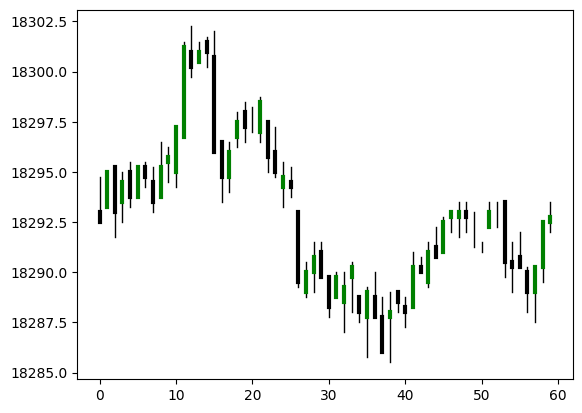

In [9]:
def plot_candles(candles):
    for index in range(len(candles)):
        candle = candles[index]
        c = "green" if candle.c > candle.o else "black"
        plt.plot([index, index], [candle.l, candle.h], linewidth=1, color = "black")
        plt.plot([index, index], [candle.c, candle.o], linewidth=3, color = c)
index+=1
step(index)
plot_candles(m.m1_candles)
if(current_position.direction != 0):
    plt.axhline(current_position.entry, color = "g" if current_position.direction == 1 else "r")
    plt.axhline(current_position.sl, color = "orange")
if(current_order != None):
    plt.axhline(current_order.entry, color = "g" if current_order.direction == 1 else "r")
    plt.axhline(current_order.sl, color = "orange")
print(current_position.direction, equity_L[-1])

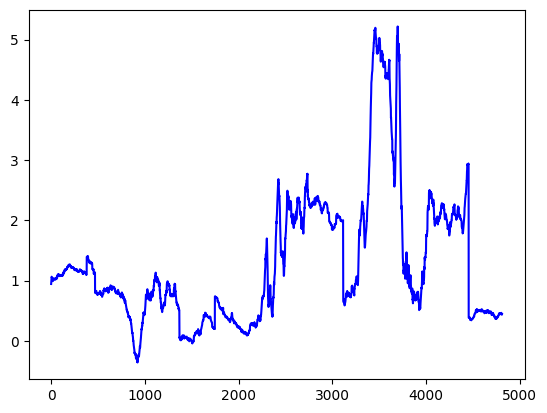

In [10]:
plt.plot([x[1]-x[0] for x in outputs], color="b")

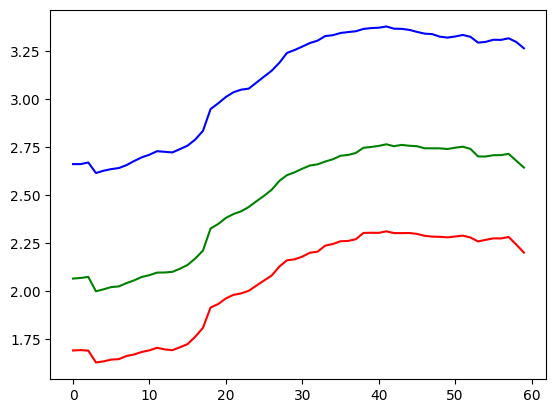

In [11]:
plt.plot([x[0] for x in outputs[-60:]], color="r")
plt.plot([x[1] for x in outputs[-60:]], color="g")
plt.plot([x[2] for x in outputs[-60:]], color="b")

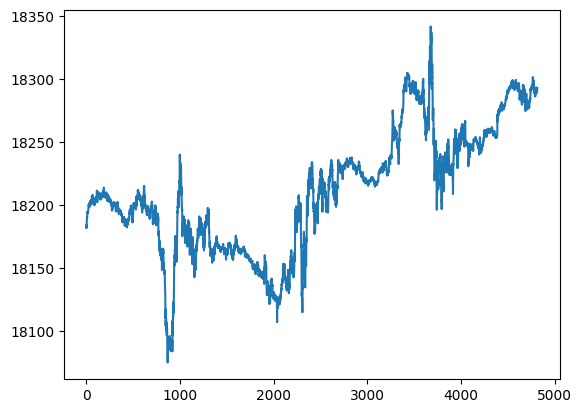

In [12]:
plt.plot([x.c for x in all_candles])

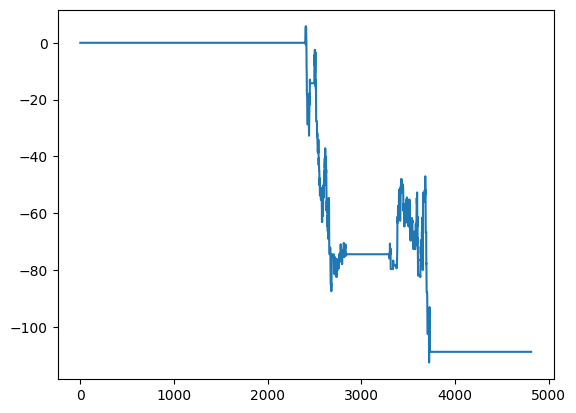

In [13]:
plt.plot(equity_L)

In [14]:
exit()